# Autoencoder

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, BatchNormalization, Dropout , Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report
from tensorflow.keras.models import Model
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers import Adam
import random
import optuna

from tensorflow.keras.models import load_model
from sklearn.metrics import make_scorer, f1_score

from sklearn.metrics import roc_curve, auc

In [2]:
data= pd.read_csv(r'C:\Users\Asus\Downloads\Thesis\dataset\data.csv')

In [4]:
sampled_data = data.sample(n=100000, random_state=42)

In [43]:
# sampled_data.head()

In [50]:
X = data.drop(columns=['anomaly'])
y = data['anomaly']

In [51]:
X_train = X.iloc[:650000, :]
X_test = X.iloc[650000:, :]
y_train = y.iloc[:650000]
y_test = y.iloc[650000:]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (650000, 20)
Test data shape: (278898, 20)


### Baseline with imbalanced implemented data

In [52]:
input_shape = X_train.shape[1]
input_data = Input(shape=(input_shape,))
encoded = Dense(32, activation="relu")(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

# Decoding layer
decoded = Dense(input_shape, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

autoencoder_train=autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),callbacks=[early_stopping],verbose=1)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460 (5.70 KB)

 Trainable params: 1,396 (5.45 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
2540/2540 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0448 - val_loss: 0.0029
Epoch 2/100
2540/2540 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 3/100
2540/2540 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0021 - val_loss: 0.0090
Epoch 4/100
2540/2540 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 5/100
2540/2540 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 6/100
2540/2540 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0015 - val_loss: 0.0037


In [53]:
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

8716/8716 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [56]:
threshold = np.percentile(mse, 85)

y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9370379135024274
Confusion Matrix:
[[226981   7478]
 [ 10082  34357]]
Precision: 0.8212501493964384
Recall: 0.7731272080829902
F1-score: 0.7964624336416534
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96    234459
         1.0       0.82      0.77      0.80     44439

    accuracy                           0.94    278898
   macro avg       0.89      0.87      0.88    278898
weighted avg       0.94      0.94      0.94    278898



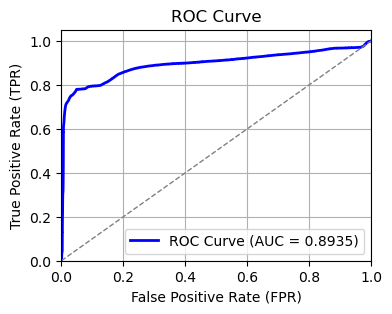

In [36]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [57]:
# Save autoencoder model trained normal inbalanced data
autoencoder.save(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\auto.keras')

### Baseline with SMOTE implemented data

In [13]:
# Create a SMOTE object
smote = SMOTE(random_state=42)

# Resample the training set
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the balance
print(y_train_smote.value_counts())

anomaly
0.0    65858
1.0    65858
Name: count, dtype: int64


In [38]:
input_shape = X_train_smote.shape[1]
input_data = Input(shape=(input_shape,))
encoded = Dense(32, activation="relu")(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.5)(encoded)

# Decoding layer
decoded = Dense(input_shape, activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

autoencoder_train=autoencoder.fit(X_train_smote, X_train_smote,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),callbacks=[early_stopping],verbose=1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,460 (5.70 KB)

 Trainable params: 1,396 (5.45 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0309 - val_loss: 0.0028
Epoch 2/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0038 - val_loss: 0.0097
Epoch 3/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0030 - val_loss: 0.0121
Epoch 4/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0028 - val_loss: 0.0165
Epoch 5/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0027 - val_loss: 0.0148
Epoch 6/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0026 - val_loss: 0.0165


In [39]:
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

8716/8716 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [40]:
threshold = np.percentile(mse, 85)

y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.891573263343588
Confusion Matrix:
[[220641  13818]
 [ 16422  28017]]
Precision: 0.6697024022947293
Recall: 0.6304597313170863
F1-score: 0.6494888378885876
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94    234459
         1.0       0.67      0.63      0.65     44439

    accuracy                           0.89    278898
   macro avg       0.80      0.79      0.79    278898
weighted avg       0.89      0.89      0.89    278898



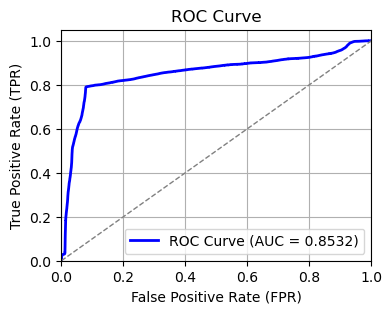

In [41]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [45]:
# Save autoencoder model trained in smote'd data
autoencoder.save(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\smote_auto.keras')

## Optimization
**grid search optimization** Best Parameters: {'activation': 'tanh', 'batch_size': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'neurons': 64}  
**random search optimization** Best Parameters: {'neurons': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 64, 'activation': 'tanh'}  
**bayesian search** Best Parameters: {'neurons': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0003327916022023467, 'batch_size': 256, 'activation': 'tanh'}

### Grid Search

In [61]:
# Define the parameter grid
param_grid = {
    'neurons': [16, 32, 64],
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [128, 256],
    'activation': ['relu', 'tanh']
}
# Initialize variables to store the best model and its performance
best_params = None
best_loss = float('inf')

In [62]:
# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    # Build the autoencoder model
    input_data = Input(shape=(X_train.shape[1],))
    encoded = Dense(params['neurons'], activation=params['activation'])(input_data)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(params['dropout_rate'])(encoded)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

    autoencoder = Model(input_data, decoded)
    optimizer = Adam(learning_rate=params['learning_rate'])
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = autoencoder.fit(
        X_train, X_train,
        epochs=15,  # Use fewer epochs for faster grid search
        batch_size=params['batch_size'],
        shuffle=True,
        validation_data=(X_test, X_test),
        verbose=0  # Suppress verbose output
    )

    # Get the validation loss from the last epoch
    val_loss = history.history['val_loss'][-1]

    print(f"Validation loss: {val_loss}")

    # Update the best parameters if this combination performs better
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params

# Print the best parameters and validation loss
print("Best Parameters:", best_params)
print("Best Validation Loss:", best_loss)

{'neurons': [16, 32, 64],
 'dropout_rate': [0.2, 0.5],
 'learning_rate': [0.001, 0.0001],
 'batch_size': [128, 256],
 'activation': ['relu', 'tanh']}

In [58]:
#decoded'de smote yazmagi unutmusan
gs_best_params = {
    'activation': 'tanh',
    'batch_size': 256,
    'dropout_rate': 0.2,
    'learning_rate': 0.001,
    'neurons': 64
}

input_data = Input(shape=(X_train_smote.shape[1],))
encoded = Dense(gs_best_params['neurons'], activation=gs_best_params['activation'])(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(gs_best_params['dropout_rate'])(encoded)
decoded = Dense(X_train_smote.shape[1], activation='sigmoid')(encoded)

gs_autoencoder = Model(input_data, decoded)
optimizer = Adam(learning_rate=gs_best_params['learning_rate'])
gs_autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the final model
gs_autoencoder.fit(
    X_train_smote, X_train_smote,
    epochs=100,  # Full training epochs
    batch_size=gs_best_params['batch_size'],
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0252 - val_loss: 0.0015
Epoch 2/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 3.8429e-04 - val_loss: 5.8840e-04
Epoch 3/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 2.6022e-04 - val_loss: 4.0022e-04
Epoch 4/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 2.1916e-04 - val_loss: 2.6558e-04
Epoch 5/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.9920e-04 - val_loss: 2.4844e-04
Epoch 6/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 1.8979e-04 - val_loss: 2.8465e-04
Epoch 7/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.8240e-04 - val_loss: 2.9151e-04
Epoch 8/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.7937e-04 - val_loss: 3.5167e-04
Epoch 9/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.7740e-04 - val_loss: 2.8612e-04
Epoch 10/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 1.7350e-04 - val_loss: 3.2542e-04


In [70]:
y_pred = gs_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

threshold = np.percentile(mse, 85)
y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

8716/8716 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.9303114400246685
Confusion Matrix:
[[226043   8416]
 [ 11020  33419]]
Precision: 0.7988287319230309
Recall: 0.7520196224037444
F1-score: 0.7747177596958528
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    234459
         1.0       0.80      0.75      0.77     44439

    accuracy                           0.93    278898
   macro avg       0.88      0.86      0.87    278898
weighted avg       0.93      0.93      0.93    278898



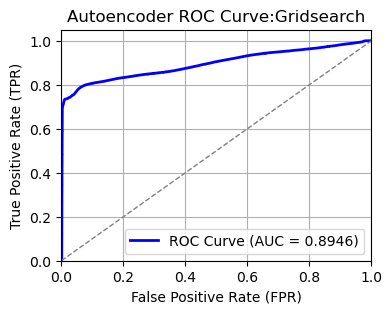

In [63]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC Curve:Gridsearch')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [71]:
# Save the final model with smote trained Grid Search
gs_autoencoder.save(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\gs_auto.keras')

### Random Search

In [72]:
# Define hyperparameter ranges
param_dist = {
    'neurons': [16, 32, 64],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'batch_size': [64, 128, 256],
    'activation': ['relu', 'tanh']
}

# Number of random combinations to try
n_iter = 10

# Initialize variables to store the best model and performance
best_params = None
best_loss = float('inf')

In [74]:
# Randomly sample hyperparameter combinations
for _ in range(n_iter):
    # Randomly select parameters
    params = {key: random.choice(values) for key, values in param_dist.items()}
    print(f"Testing parameters: {params}")

    # Build the autoencoder
    input_data = Input(shape=(X_train.shape[1],))
    encoded = Dense(params['neurons'], activation=params['activation'])(input_data)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(params['dropout_rate'])(encoded)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

    autoencoder = Model(input_data, decoded)
    optimizer = Adam(learning_rate=params['learning_rate'])
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = autoencoder.fit(
        X_train, X_train,
        epochs=20,  # Fewer epochs for faster random search
        batch_size=params['batch_size'],
        shuffle=True,
        validation_data=(X_test, X_test),
        verbose=0
    )

    # Get validation loss from the last epoch
    val_loss = history.history['val_loss'][-1]
    print(f"Validation Loss: {val_loss}")

    # Update the best parameters if this model is better
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params

# Print the best parameters and validation loss
print("Best Parameters:", best_params)
print("Best Validation Loss:", best_loss)

{'activation': 'tanh',
 'batch_size': 64,
 'dropout_rate': 0.2,
 'learning_rate': 0.001,
 'neurons': 64}

In [65]:
rs_best_params = {
    'activation': 'tanh',
    'batch_size': 64,
    'dropout_rate': 0.2,
    'learning_rate': 0.001,
    'neurons': 64
}

input_data = Input(shape=(X_train_smote.shape[1],))
encoded = Dense(rs_best_params['neurons'], activation=rs_best_params['activation'])(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(rs_best_params['dropout_rate'])(encoded)
decoded = Dense(X_train_smote.shape[1], activation='sigmoid')(encoded)

rs_autoencoder = Model(input_data, decoded)
optimizer = Adam(learning_rate=rs_best_params['learning_rate'])
rs_autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the final model
rs_autoencoder.fit(
    X_train_smote, X_train_smote,
    epochs=100,  # Full training epochs
    batch_size=rs_best_params['batch_size'],
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
20025/20025 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0089 - val_loss: 0.0012
Epoch 2/100
20025/20025 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 3.1058e-04 - val_loss: 6.1425e-04
Epoch 3/100
20025/20025 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 2.7641e-04 - val_loss: 5.1636e-04
Epoch 4/100
20025/20025 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.6550e-04 - val_loss: 6.5593e-04
Epoch 5/100
20025/20025 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 2.5803e-04 - val_loss: 7.0895e-04


In [66]:
y_pred = rs_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

threshold = np.percentile(mse, 85)
y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

8716/8716 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9270987959755896
Confusion Matrix:
[[225595   8864]
 [ 11468  32971]]
Precision: 0.788119995219314
Recall: 0.7419383874524629
F1-score: 0.7643322437814405
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    234459
         1.0       0.79      0.74      0.76     44439

    accuracy                           0.93    278898
   macro avg       0.87      0.85      0.86    278898
weighted avg       0.93      0.93      0.93    278898



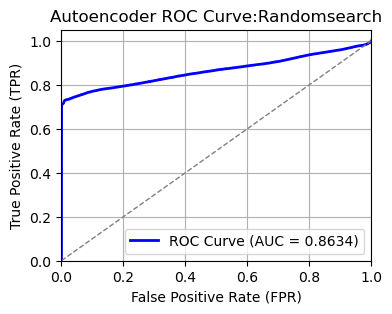

In [68]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC Curve:Randomsearch')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [75]:
rs_autoencoder.save(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\rs_auto.keras')

### Bayesian

In [82]:
def objective(trial):
    # Suggest hyperparameters
    neurons = trial.suggest_categorical('neurons', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])

    # Build the autoencoder
    input_data = Input(shape=(X_train.shape[1],))
    encoded = Dense(neurons, activation=activation)(input_data)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

    autoencoder = Model(input_data, decoded)
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = autoencoder.fit(
        X_train, X_train,
        epochs=20,  # Fewer epochs for faster optimization
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_test, X_test),
        verbose=0
    )

    # Return the validation loss from the last epoch
    return history.history['val_loss'][-1]
 
# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best parameters and validation loss
print("Best Parameters:", study.best_params)
print("Best Validation Loss:", study.best_value)

{'activation': 'tanh',
 'batch_size': 256,
 'dropout_rate': 0.2,
 'learning_rate': 0.0003327916022023467,
 'neurons': 64}

In [76]:
bs_best_params = {
    'activation': 'tanh',
    'batch_size': 256,
    'dropout_rate': 0.2,
    'learning_rate': 0.0003327916022023467,
    'neurons': 64
}

input_data = Input(shape=(X_train_smote.shape[1],))
encoded = Dense(bs_best_params['neurons'], activation=bs_best_params['activation'])(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(bs_best_params['dropout_rate'])(encoded)
decoded = Dense(X_train_smote.shape[1], activation='sigmoid')(encoded)

bs_autoencoder = Model(input_data, decoded)
optimizer = Adam(learning_rate=bs_best_params['learning_rate'])
bs_autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the final model
bs_autoencoder.fit(
    X_train_smote, X_train_smote,
    epochs=100,  # Full training epochs
    batch_size=bs_best_params['batch_size'],
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0466 - val_loss: 0.0016
Epoch 2/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 9.4449e-04 - val_loss: 0.0012
Epoch 3/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 3.9023e-04 - val_loss: 0.0013
Epoch 4/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.9453e-04 - val_loss: 0.0011
Epoch 5/100
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 2.5818e-04 - val_loss: 0.0012


In [77]:
y_pred = bs_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

threshold = np.percentile(mse, 85)
y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

8716/8716 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Accuracy: 0.9296230162998659
Confusion Matrix:
[[225947   8512]
 [ 11116  33323]]
Precision: 0.7965340026293773
Recall: 0.749859357771327
F1-score: 0.7724922919999072
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    234459
         1.0       0.80      0.75      0.77     44439

    accuracy                           0.93    278898
   macro avg       0.87      0.86      0.87    278898
weighted avg       0.93      0.93      0.93    278898



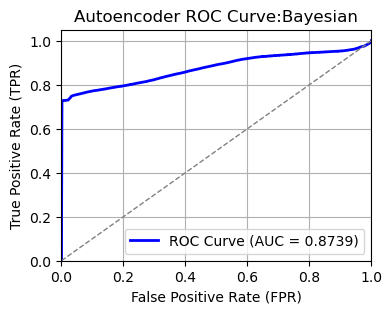

In [79]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC Curve:Bayesian')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [80]:
# Save bayesian optimized with smoted trained data
bs_autoencoder.save(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\bs_autoen.keras')

### PSO optimization

In [2]:
from pyswarm import pso

In [6]:
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

In [7]:
X_train = X.iloc[:70000, :]
X_test = X.iloc[70000:, :]
y_train = y.iloc[:70000]
y_test = y.iloc[70000:]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (70000, 20)
Test data shape: (30000, 20)


In [10]:
def find_anomalies(original_data, reconstructed_data, threshold=0.01):
    # Calculate mean squared error from original and reconstructed data
    mse = np.mean(np.power(original_data - reconstructed_data, 2), axis=1)
    # If mse is greater than a threshold, it's an anomaly
    anomalies = mse > threshold
    return anomalies.astype(int)

In [11]:
def optimize_autoencoder(params):
    # Unpack parameters from PSO
    neurons, dropout_rate, learning_rate = int(params[0]), params[1], params[2]

    # Building the autoencoder model
    input_data = Input(shape=(X_train.shape[1],))
    encoded = Dense(neurons, activation='relu')(input_data)
    encoded = Dropout(dropout_rate)(encoded)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

    # Compile the autoencoder
    autoencoder = Model(inputs=input_data, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_data=(X_test, X_test), callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    reconstructed = autoencoder.predict(X_test)
    anomalies = find_anomalies(X_test, reconstructed)  # Define how you identify anomalies based on reconstruction error
    f1 = f1_score(y_test, anomalies)
    recall = recall_score(y_test, anomalies)

    # Calculate the weighted score combining F1 and Recall
    weighted_score = 0.5 * f1 + 0.5 * recall
    return -weighted_score  # Minimize the negative score for optimization

# Define parameter bounds for neurons, dropout rate, and learning rate
lb = [50, 0.1, 0.0001]  # Lower bounds
ub = [500, 0.5, 0.01]   # Upper bounds

# Run PSO
xopt, fopt = pso(optimize_autoencoder, lb, ub, swarmsize=20, maxiter=50)
print("Best parameters found:", xopt)
print("Best weighted score:", -fopt)

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
938/938 ━━━━━━

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
938/938 ━━━━━━

In [44]:
threshold

0.00022611084887329144

In [46]:
pso_best_params = {
    'dropout_rate': 0.345,
    'learning_rate': 0.0001,
    'neurons': 50
}

input_data = Input(shape=(X_train.shape[1],))
encoded = Dense(pso_best_params['neurons'], activation='tanh')(input_data)
encoded = BatchNormalization()(encoded)
encoded = Dropout(pso_best_params['dropout_rate'])(encoded)
decoded = Dense(X_train.shape[1], activation='tanh')(encoded)

pso_autoencoder2 = Model(input_data, decoded)
optimizer = Adam(learning_rate=pso_best_params['learning_rate'])
pso_autoencoder2.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the final model
pso_autoencoder2.fit(
    X_train, X_train,
    epochs=100,  # Full training epochs
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7905 - val_loss: 0.2099
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4500 - val_loss: 0.1383
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2526 - val_loss: 0.0831
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1538 - val_loss: 0.0635
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1127 - val_loss: 0.0546
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0895 - val_loss: 0.0457
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0729 - val_loss: 0.0430
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0658 - val_loss: 0.0421
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0612 - val_loss: 0.0412
Epoch 10/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0586 - val_loss: 0.0401
Epoch 11/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0552 - val_loss: 0.0395
Epoch 12/100
274/274 ━━━━━━━━━━━━━━━━━━━━

In [50]:
y_pred = pso_autoencoder2.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

threshold = np.percentile(mse, 80)
y_pred = (mse > threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.8284666666666667
Confusion Matrix:
[[23594  4740]
 [  406  1260]]
Precision: 0.21
Recall: 0.7563025210084033
F1-score: 0.3287242368901644
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     28334
         1.0       0.21      0.76      0.33      1666

    accuracy                           0.83     30000
   macro avg       0.60      0.79      0.62     30000
weighted avg       0.94      0.83      0.87     30000



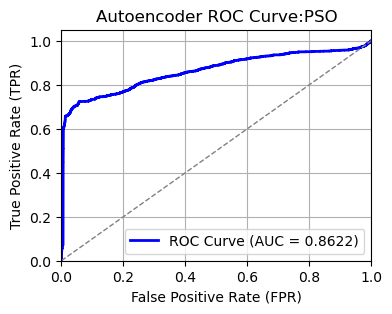

In [52]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC Curve:PSO')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [51]:
# Save bayesian optimized with normal trained data
pso_autoencoder2.save(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\pso_autoen.keras')

## Different Splitting

### k-fold cross validation

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import tensorflow as tf

In [7]:
sampled_data = data.sample(n=10000, random_state=42)
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

In [5]:
grid = load_model(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\gs_auto.keras')
random = load_model(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\rs_auto.keras')
pso = load_model(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\pso_autoen.keras')
bayes = load_model(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\bs_autoen.keras')

In [8]:
# Assuming X and y are your features and labels
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store AUC scores for each model
auc_scores_pso = []
auc_scores_grid = []
auc_scores_random = []
auc_scores_bayesian = []

# Iterate through k-folds and compute AUC for each model
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)

    # PSO model
    pso_predictions = pso.predict(X_test_fold)
    mse_pso = np.mean(np.power(X_test_fold - pso_predictions, 2), axis=1)
    fpr_pso, tpr_pso, _ = roc_curve(y_test_fold, mse_pso)
    auc_scores_pso.append(auc(fpr_pso, tpr_pso))

    # Grid Search model
    grid_predictions = grid.predict(X_test_fold)
    mse_grid = np.mean(np.power(X_test_fold - grid_predictions, 2), axis=1)
    fpr_grid, tpr_grid, _ = roc_curve(y_test_fold, mse_grid)
    auc_scores_grid.append(auc(fpr_grid, tpr_grid))

    # Random Search model
    random_predictions = random.predict(X_test_fold)
    mse_random = np.mean(np.power(X_test_fold - random_predictions, 2), axis=1)
    fpr_random, tpr_random, _ = roc_curve(y_test_fold, mse_random)
    auc_scores_random.append(auc(fpr_random, tpr_random))

    # Bayesian Optimization model
    bayesian_predictions = bayes.predict(X_test_fold)
    mse_bayesian = np.mean(np.power(X_test_fold - bayesian_predictions, 2), axis=1)
    fpr_bayesian, tpr_bayesian, _ = roc_curve(y_test_fold, mse_bayesian)
    auc_scores_bayesian.append(auc(fpr_bayesian, tpr_bayesian))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32

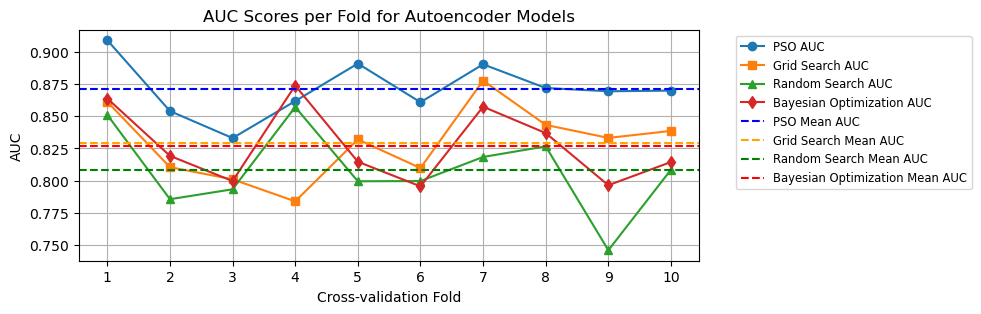

In [14]:
# Plotting the AUC scores for each model
plt.figure(figsize=(8, 3))
folds = list(range(1, len(auc_scores_pso) + 1))

# Plot AUC scores for each model
plt.plot(folds, auc_scores_pso, marker='o', label='PSO AUC')
plt.plot(folds, auc_scores_grid, marker='s', label='Grid Search AUC')
plt.plot(folds, auc_scores_random, marker='^', label='Random Search AUC')
plt.plot(folds, auc_scores_bayesian, marker='d', label='Bayesian Optimization AUC')

# Add mean AUC as horizontal lines
plt.axhline(np.mean(auc_scores_pso), color='blue', linestyle='--', label='PSO Mean AUC')
plt.axhline(np.mean(auc_scores_grid), color='orange', linestyle='--', label='Grid Search Mean AUC')
plt.axhline(np.mean(auc_scores_random), color='green', linestyle='--', label='Random Search Mean AUC')
plt.axhline(np.mean(auc_scores_bayesian), color='red', linestyle='--', label='Bayesian Optimization Mean AUC')

# Customize plot
plt.xlabel('Cross-validation Fold')
plt.ylabel('AUC')
plt.title('AUC Scores per Fold for Autoencoder Models')
plt.xticks(folds)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)

plt.show()

#### k fold only choosedn grid search

In [90]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
auc_scores = []
fold_predictions = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_fold, y_train_fold)

    # Predict on test data
    predictions = gs_autoencoder.predict(X_test_fold)
    mse = np.mean(np.power(X_test_fold - predictions, 2), axis=1)
    fpr, tpr, _ = roc_curve(y_test_fold, mse)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Store predictions for visualization
    fold_predictions.append((fpr, tpr))

2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


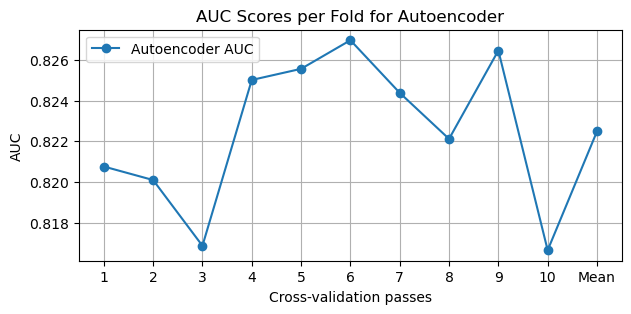

In [93]:
plt.figure(figsize=(7, 3))
plt.plot(range(1, 12), auc_scores + [np.mean(auc_scores)], marker='o', label='Autoencoder AUC')
plt.xticks(list(range(1, 12)), labels=list(range(1, 11)) + ['Mean'])
plt.xlabel('Cross-validation passes')
plt.ylabel('AUC')
plt.title('AUC Scores per Fold for Autoencoder')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
#download the best performiing model
autoencoder = load_model(r'C:\Users\Asus\Downloads\Thesis\models\model\auto\gs_auto.keras')

### 80/20 Test Splitting

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743118, 20)
Test data shape: (185780, 20)


In [141]:
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

5806/5806 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [142]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, mse)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]

print(f"Optimal threshold by F1-score: {optimal_threshold}")
print(f"Maximum F1-score: {f1_scores[max_f1_index]}")

Optimal threshold by F1-score: 0.004307005531441907
Maximum F1-score: 0.7358998361806693


In [150]:
y_pred_class = (mse > optimal_threshold).astype(int)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_class, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

Precision: 0.9882
Recall: 0.5861
F1 Score: 0.7358
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    175052
         1.0       0.99      0.59      0.74     10728

    accuracy                           0.98    185780
   macro avg       0.98      0.79      0.86    185780
weighted avg       0.98      0.98      0.97    185780



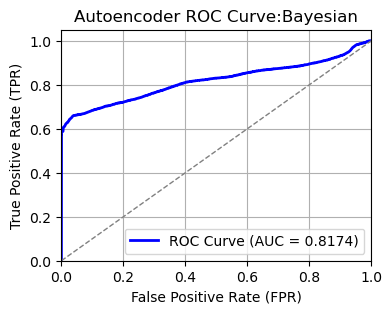

In [151]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC Curve:Bayesian')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 90/10 Test Splitting

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

Training data shape: (836008, 20)
Test data shape: (92890, 20)
2903/2903 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [153]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, mse)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]

print(f"Optimal threshold by F1-score: {optimal_threshold}")
print(f"Maximum F1-score: {f1_scores[max_f1_index]}")

Optimal threshold by F1-score: 0.004307005531441907
Maximum F1-score: 0.7382843983880254


In [154]:
y_pred_class = (mse > optimal_threshold).astype(int)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_class, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

Precision: 0.9877
Recall: 0.5893
F1 Score: 0.7381
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     87451
         1.0       0.99      0.59      0.74      5439

    accuracy                           0.98     92890
   macro avg       0.98      0.79      0.86     92890
weighted avg       0.98      0.98      0.97     92890



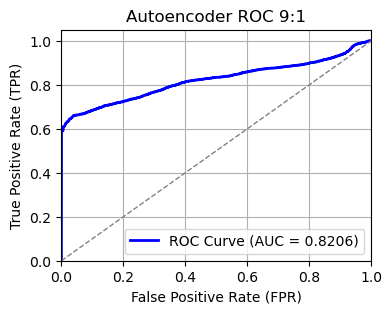

In [158]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC 9:1')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 60/40 Test Splitting

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

Training data shape: (557338, 20)
Test data shape: (371560, 20)
11612/11612 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [160]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, mse)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]

print(f"Optimal threshold by F1-score: {optimal_threshold}")
print(f"Maximum F1-score: {f1_scores[max_f1_index]}")

Optimal threshold by F1-score: 0.004307005531441907
Maximum F1-score: 0.7405194881255672


In [161]:
y_pred_class = (mse > optimal_threshold).astype(int)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_class, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

Precision: 0.9883
Recall: 0.5920
F1 Score: 0.7405
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    350205
         1.0       0.99      0.59      0.74     21355

    accuracy                           0.98    371560
   macro avg       0.98      0.80      0.86    371560
weighted avg       0.98      0.98      0.97    371560



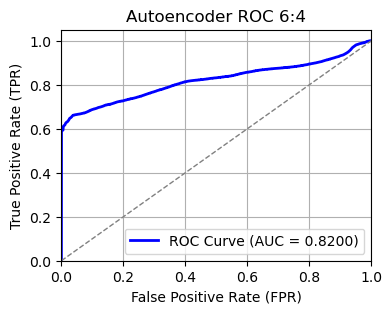

In [162]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC 6:4')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 70/30 Test Splitting

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

Training data shape: (650228, 20)
Test data shape: (278670, 20)
8709/8709 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [164]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, mse)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_index]

print(f"Optimal threshold by F1-score: {optimal_threshold}")
print(f"Maximum F1-score: {f1_scores[max_f1_index]}")

Optimal threshold by F1-score: 0.0037198313954831023
Maximum F1-score: 0.7413933630894625


In [165]:
y_pred_class = (mse > optimal_threshold).astype(int)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_class, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

Precision: 0.9880
Recall: 0.5932
F1 Score: 0.7413
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    262572
         1.0       0.99      0.59      0.74     16098

    accuracy                           0.98    278670
   macro avg       0.98      0.80      0.86    278670
weighted avg       0.98      0.98      0.97    278670



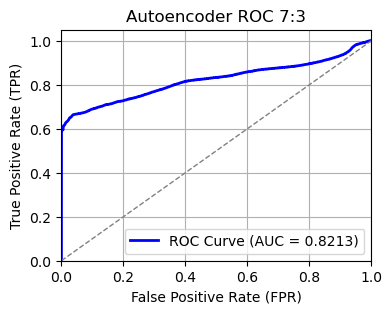

In [166]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Autoencoder ROC 7:3')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### AUC curve results per splitting ratio

In [15]:
split_ratios = ['7:3', '6:4', '9:1', '8:2']
auc_scores = [0.8213, 0.8200, 0.8206, 0.8174]

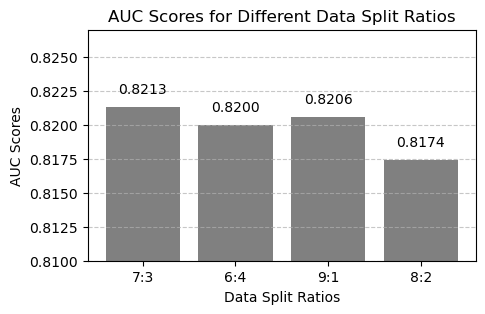

In [18]:
# Creating the plot
plt.figure(figsize=(5, 3))
plt.bar(split_ratios, auc_scores, color='gray')

# Adding titles and labels
plt.xlabel('Data Split Ratios')
plt.ylabel('AUC Scores')
plt.title('AUC Scores for Different Data Split Ratios')
plt.ylim([0.81, 0.827])  # Adjust the y-axis limits to make differences more visible

# Adding the AUC scores on top of each bar for clarity
for i in range(len(auc_scores)):
    plt.text(i, auc_scores[i] + 0.001, f'{auc_scores[i]:.4f}', ha = 'center', color = 'black')

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()